### Faire Direct Analytics Case

By: Jack Keane  
[Github link](https://github.com/jwkeane1/Faire_Direct_Analytics_Case.git) 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Summary
---

### The problem:

- Faire Direct has experienced a 26.5% decrease in new retailer acquisitions (i.e., first confirmed orders) between 5/27 and 6/10.

### The explanatory hypotheses:

1. Brands send more invites to retailers within 14 days of adopting Faire Direct, and fewer brands adopted Faire Direct between 5/27 and 6/10.
2. Retailer sign-ups are highly correlated with confirmed first orders, and fewer retailers signed up between 5/27 and 6/10.
3. Most retailers make their first confirmed orders within 7-10 days of joining Faire Direct, and fewer retailers joined Faire Direct between 5/27 and 6/10.

### The product solutions:
1. Nudging brands to invite retailers at 2, 4, and 6 weeks after the brand adopts Faire Direct.
2. Increasing incentives for brands to join Faire Direct during down weeks.
3. Reducing the friction in retailer onboarding from invite click-through to confirmed sign-up.
4. Auto-populating retailer carts with recommendation engine suggestions 14 days after joining Faire Direct.


# Analysis
---

## Quantifying the problem

- In recent weeks, the number of new Faire Direct retailers acquired has declined. 

- Before beginning to address the issue, we'll first want to understand the magnitude of the decrease.

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import the case data into a Pandas DataFrame
clicks = pd.read_csv('elevate_analytics_case_data.csv', low_memory=False)

# Convert the confirmed first order and sign-up timestamps to datetime
clicks['retailer_placed_first_confirmed_order_at'] = pd.to_datetime(
    clicks['retailer_placed_first_confirmed_order_at'])

clicks['brand_relationship_confirmed_at'] = pd.to_datetime(clicks['brand_relationship_confirmed_at'])


# Create a DataFrame with only retailers with confirmed first orders
retailers_with_confirmed_orders = clicks.loc[clicks['retailer_placed_first_confirmed_order_at'].notnull()]

# Group the count of new retailers by week
new_retailers_by_week = retailers_with_confirmed_orders['retailer_placed_first_confirmed_order_at'].groupby(
    retailers_with_confirmed_orders['retailer_placed_first_confirmed_order_at'].dt.week).count()

# Filter the grouped-by-week count to the select weeks in question
new_retailers_by_week_filtered = new_retailers_by_week.iloc[8:24]

In [4]:
# A function from StackOverflow to add value labels to each bar in a bar plot
def add_value_labels(ax, spacing=5):
    """ 
    Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
        
    SOURCE: https://stackoverflow.com/a/48372659
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        # label = "{:.1f}".format(y_value)
        label = int(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


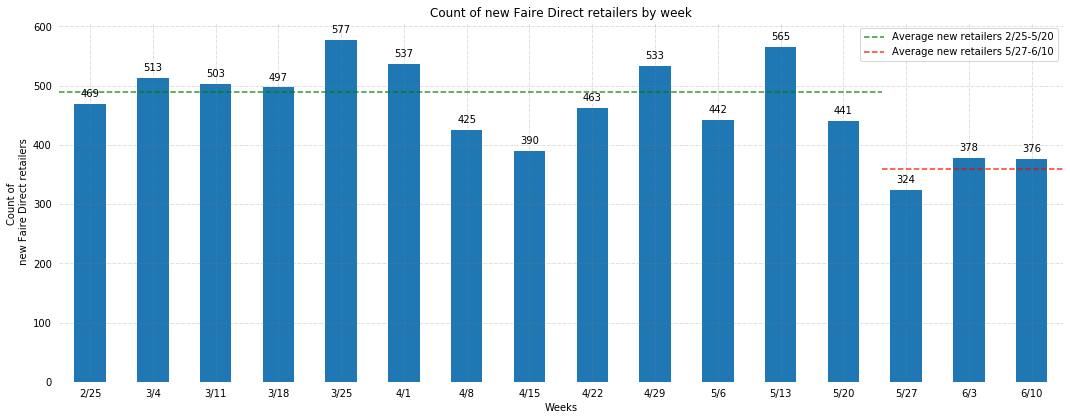

In [5]:
# Plot and annotate the count of new retailers by week
ax = new_retailers_by_week_filtered.plot(kind='bar', figsize=(18,6.6), rot=0)
ax.set_xlabel('Weeks')
ax.set_ylabel('Count of \n new Faire Direct retailers', rotation=90)
week_labels = ['2/25', '3/4', '3/11', '3/18', '3/25', '4/1', '4/8', '4/15', '4/22', '4/29',
               '5/6', '5/13', '5/20', '5/27', '6/3', '6/10']
ax.set_xticklabels(week_labels)

# Add x, y gridlines 
ax.grid(b=True, color='grey', 
        linestyle='-.', linewidth=0.5, 
        alpha=0.5)

# Add Plot Title 
ax.set_title('Count of new Faire Direct retailers by week', 
             loc ='center', )

# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False) 
    
# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 

# Find and plot the average count of new Faire Direct retailers by week
avg_new_retailers = new_retailers_by_week_filtered.iloc[:-3].mean()
final_three_weeks_avg = new_retailers_by_week_filtered.iloc[-3:].mean()
line1 = ax.axhline(y=avg_new_retailers, xmax=0.82, color='g', linestyle='--', alpha=0.8)
line2 = ax.axhline(y=final_three_weeks_avg, xmin=0.82, color='r', linestyle='--', alpha=0.8)

ax.legend((line1, line2), ('Average new retailers 2/25-5/20', 'Average new retailers 5/27-6/10'))


add_value_labels(ax)

# Calculate the percentage descrease in new retailers signups during weeks 22-24
pct_decrease = ((avg_new_retailers - final_three_weeks_avg) / avg_new_retailers) * 100

The data show:

- **489** new retailers joined Faire Direct each week between 2/25 and 5/20, on average.
- **360** new retailers joined Faire Direct between 5/27 and 6/10, on average.
- **26.5%** average decrease in new retailers between 5/27 and 6/10. 

This analysis will investigate potential causes for this decrease and suggest product solutions to lift the number of new Faire Direct retailers joining the platform.

# Strategy
---
We will investigate three stages of the retailer acquisition funnel and make targeted product recommendations for each stage:  

**1. Brand invitations**  
**2. Retailer sign-ups**  
**3. First retailer orders** 



# 1. Brand invitation behavior
---

**Hypothesis: Brands send most invites within two weeks of joining Faire Direct. Fewer brands joined Faire Direct in weeks between 5/27 and 6/10.**

To test this hypothesis, we will:

**a**. Investigate when brands are more likely to invite retailers.  
**b**. Investigate how many brands joined Faire Direct between 5/27 and 6/10 compared to an average week.

**1a: When do brands invite retailers?**  
* We'll use the difference between `brand_adopted_elevate_at` and `brand_relationship_created_at` to calculate the number of days between a brand adopting Faire Direct and the brand inviting a retailer.
* Then we'll plot a histogram of these date differences to understand the distribution of brand invite behavior.



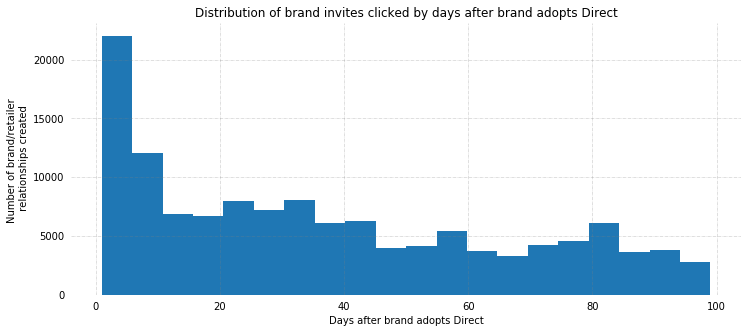

In [6]:
# Convert columns in question to datetime
clicks['brand_relationship_created_at'] = pd.to_datetime(clicks['brand_relationship_created_at'])
clicks['brand_adopted_elevate_at'] = pd.to_datetime(clicks['brand_adopted_elevate_at'])

# Calculate the number of days between brand_adopted_elevate_at and brand_relationship_created_at
clicks['adopt_invite_date_dif'] = (clicks['brand_relationship_created_at'] - clicks['brand_adopted_elevate_at']).dt.days

# Trim outliers and plot a histogram of adopt_invite_date_dif
ax2 = clicks.loc[(
    clicks['adopt_invite_date_dif'] < 100) & (clicks['adopt_invite_date_dif'] > 0), 'adopt_invite_date_dif'].hist(figsize=(12,5), bins=20)
ax2.set_xlabel('Days after brand adopts Direct')
ax2.set_ylabel('Number of brand/retailer \n relationships created')
ax2.set_title('Distribution of brand invites clicked by days after brand adopts Direct', loc='center')

# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax2.spines[s].set_visible(False) 
    
# Remove x, y Ticks 
ax2.xaxis.set_ticks_position('none') 
ax2.yaxis.set_ticks_position('none') 

# Add x, y gridlines 
ax2.grid(b=True, color='grey', 
        linestyle='-.', linewidth=0.5, 
        alpha=0.5)


- The histogram above shows that the distrubution of brand invites is heavily weighted towards the first 14 days after a brand adopts Direct.
- This **confirms** the first step in our hypothesis - **brands tend to invite more retailers in the 14 days after they adopt Direct.**

**1b: How many brands adopted Faire Direct each week between 5/27 and 6/10 compared average?** 
- Next, we'll analyze the number of unique brands that adopt Faire Direct each week.

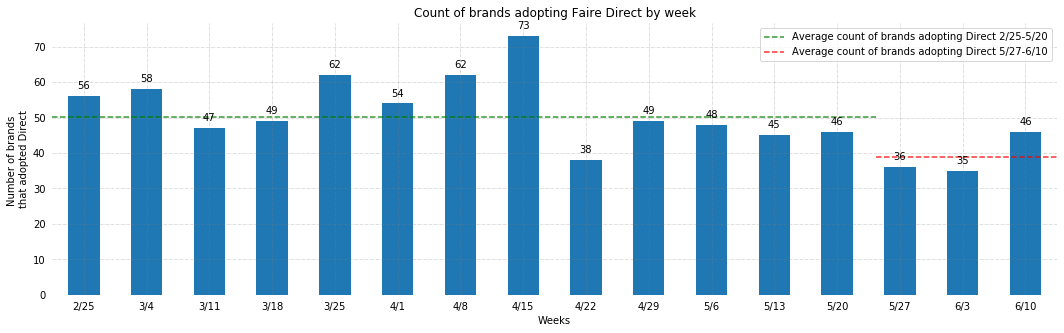

In [7]:
# Find which brands adopted Faire Direct during our target window of time
earliest_click = clicks['brand_relationship_created_at'].min()
latest_click = clicks['brand_relationship_created_at'].max()

brands = clicks.loc[
    (clicks['brand_adopted_elevate_at'] > earliest_click) & (clicks['brand_adopted_elevate_at'] < latest_click)].drop_duplicates(subset='brand_id')

# Group brand_adopt_elevate_at by week and count

grouped_brands = brands['brand_adopted_elevate_at'].groupby(brands['brand_adopted_elevate_at'].dt.week).count()
grouped_brands = grouped_brands.iloc[8:24]

# Plot the count of brand adoptions by week
ax3 = grouped_brands.plot(kind='bar', figsize=(18,5), rot=0)

# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax3.spines[s].set_visible(False) 
    
# Remove x, y Ticks 
ax3.xaxis.set_ticks_position('none') 
ax3.yaxis.set_ticks_position('none') 

# Add x, y gridlines 
ax3.grid(b=True, color='grey', 
        linestyle='-.', linewidth=0.5, 
        alpha=0.5)

# Add Plot Title and labels
ax3.set_title('Count of brands adopting Faire Direct by week', 
             loc ='center', )
ax3.set_xlabel('Weeks')
ax3.set_ylabel('Number of brands \nthat adopted Direct')
ax3.set_xticklabels(week_labels)

# Plot lines through the averages
avg_adoptions = grouped_brands.mean()
avg_adoptions_last_weeks = grouped_brands.iloc[-3:].mean()
line3 = ax3.axhline(y=avg_adoptions, xmax=0.82, color='g', linestyle='--', alpha=0.8)
line4 = ax3.axhline(y=avg_adoptions_last_weeks, xmin=0.82, color='r', linestyle='--', alpha=0.8)
ax3.legend((line3, line4), ('Average count of brands adopting Direct 2/25-5/20', 'Average count of brands adopting Direct 5/27-6/10'))
add_value_labels(ax3)

# Calculate the percentage decrease of brands adopting Faire Direct in weeks 22-24
pct_adoption_decrease = ((avg_adoptions_last_weeks - avg_adoptions) / avg_adoptions) * 100



The data show:

- **50** brands adopted Faire Direct each week between 2/25 and 5/20, on average.
- **39** brands adopted Faire Direct each week between 5/27 and 6/10, on average.
- **22%** average decrease in the number of brands adopting Faire Direct between 5/27 and 6/10. 


- This **confirms** the second step in our hypothesis - **fewer brands adopted Faire Direct between 5/27 and 6/10.** 

> **In conclusion:** We can deduce from Hypothesis 1 that the decrease in new retailers acquired between 5/27 and 6/10 can be explained in part by:
> - Brands send most invites within two weeks of adopting Faire Direct.
> - Fewer brands adopted Faire Direct between 5/27 and 6/10.

## Product Recommendations 

After confirming our first hypothesis, we have two key takeaways:  

1. Brands invite more retailers in the two weeks after adopting Faire Direct than any other peroid of time.  
2. 22% fewer brands adopted Faire Direct in weeks between 5/27 and 6/10 than average.


To address each of these takeaways, I propose:

1. **Nudging brands to invite retailers at 2, 4, and 6 weeks after adopting Faire Direct.**  
    - By sending recurring in-platform messages to brands nudging them to invite retailers, we will address the steep decline in brand invite behavior 14 days after brands adopt Faire Direct.  
    
    **Goal:** Increase the overall number of retailer invitations by brands with more than 14 days on Faire Direct by 25% YoY.
    
    **Measurement:** Conduct an A/B test with randomly sampled brand cohorts to evaluate if an in-platform message increases the number of retailers invited by brands with more than 14 days on Faire Direct. Additionally, we will analyze the second nudge to learn if the follow-up intervention is successful, and adjust the number of interventions and the period between them, if necessary. 
    
    **Lift:** 5 engineering story points to create and 2 story points to test.   
    
    **ROI:** I estimate that the downstream effect of hitting the goal will result in a 5% increase in new retailers acquired, leading to a \\$500,000 increase in annual revenue. 
    
    
    

2. **Increasing incentives for brands to join Faire Direct during down weeks.**
    - By offering time-restricted incentives for brands on Faire to join Faire Direct during periods like 5/27 - 6/10, the platform will maintain a steady cadence of new brand adoptions, and thus new retailer invitations. 
    
    **Goal:** Increase the average number of brands adopting Faire Direct each week by 10% YoY.
    
    **Measurement:** Conduct an A/B test with randomly sampled cohorts of brands using Faire but not Faire Direct to evaluate if increased incentives drive a greater number of brands to adopt Faire Direct.
    
    **Lift:** 6 Engineering story points to create and 2 story points to test.   
    
    **Cost:** I estimate that the cost of the increased incentives will amount to \$50,000 per year.
    
    **ROI:** I estimate the downstream effect of hitting the goal will result in a 2% increase in new retailers acquired, leading to a \\$200,000 increase in annual revenue. This revenue increase less the cost of the incentives will result in a \$150,000 annual ROI.

    

    
 

# 2. Retailer sign-ups
---

**Hypothesis: There is a positive correlation between confirmed retailer relationships (sign-ups) and first orders. Fewer retailer relationships were confirmed during weeks between 5/27 and 6/10.**

To test this hypothesis, we will:  
    
   **a.** Measure the correlation between weekly confirmed new retailer relationships and confirmed first orders.  
   **b.** Measure the number of confirmed retailer sign-ups during weeks between 5/27 and 6/10.

**2a. What's the relationship between confirmed retailer sign-ups and confirmed first orders?**  
   - First, we'll group `brand_relationship_confirmed_at` and `retailer_placed_first_confirmed_order_at` by week.
       - Note: `brand_relationship_confirmed_at` indicates when a retailer signs up for Faire Direct.
   - Second, we'll perform a linear regression on the two variables and measure their correlation.


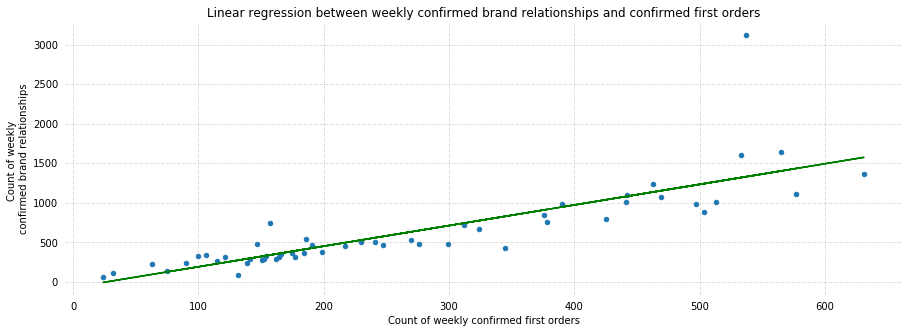

In [8]:
# Convert column in question to datetime
clicks['brand_relationship_confirmed_at'] = pd.to_datetime(clicks['brand_relationship_confirmed_at'])

# Create a DataFrame with only retailers with confirmed brand relationships
confirmed_relationships = clicks.loc[clicks['brand_relationship_confirmed_at'].notnull()]

# Group the count of new retailers by week
confirmed_relationships_by_week = confirmed_relationships['brand_relationship_confirmed_at'].groupby(
    confirmed_relationships['brand_relationship_confirmed_at'].dt.week).count()

# Filter the grouped-by-week count to the select weeks in question
# confirmed_retailers_by_week = confirmed_retailers_by_week.iloc[8:24]

# Join the confirmed retailers by week DataFrame with the first orders by week DataFrame.
confirmed_relationships_by_week = pd.DataFrame(confirmed_relationships_by_week)
confirmed_retailers_by_week = pd.DataFrame(new_retailers_by_week)
conf_retailers_and_orders = confirmed_retailers_by_week.join(confirmed_relationships_by_week)
cols = ['Count of weekly confirmed first orders', 'Count of weekly confirmed brand relationships']
conf_retailers_and_orders.columns = cols

# Run a linear regression on the two columns
x = conf_retailers_and_orders['Count of weekly confirmed first orders'].values
y = conf_retailers_and_orders['Count of weekly confirmed brand relationships'].values
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 

# Plot the regression
ax4 = conf_retailers_and_orders.plot(kind='scatter', x='Count of weekly confirmed first orders',
                               y='Count of weekly confirmed brand relationships', figsize=(15,5))
ax4.plot(x, poly1d_fn(x), '-g')
ax4.set_xlabel('Count of weekly confirmed first orders')
ax4.set_ylabel('Count of weekly \nconfirmed brand relationships')
ax4.set_title('Linear regression between weekly confirmed brand relationships and confirmed first orders')
add_value_labels(ax4)

# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax4.spines[s].set_visible(False) 
    
# Remove x, y Ticks 
ax4.xaxis.set_ticks_position('none') 
ax4.yaxis.set_ticks_position('none') 

# Add x, y gridlines 
ax4.grid(b=True, color='grey', 
        linestyle='-.', linewidth=0.5, 
        alpha=0.5)

# Calculate the correlation coefficient
corrcoef = conf_retailers_and_orders['Count of weekly confirmed first orders'].corr(
    conf_retailers_and_orders['Count of weekly confirmed brand relationships'])

The data show:
   - A strong positive correlation (r = 0.82) between the number of weekly confirmed brand relationships and weekly confirmed first orders.
   
   
   - This **confirms** the first step in our hypothesis - **there is a positive relationship between weekly confirmed brand relationships and weekly confirmed first orders.**


**2b: How many new brand relationships were confirmed in weeks between 5/27 and 6/10 compared to an average week?**  
   - Next, we'll visualize and compare the number of confirmed brand relationships across weeks.

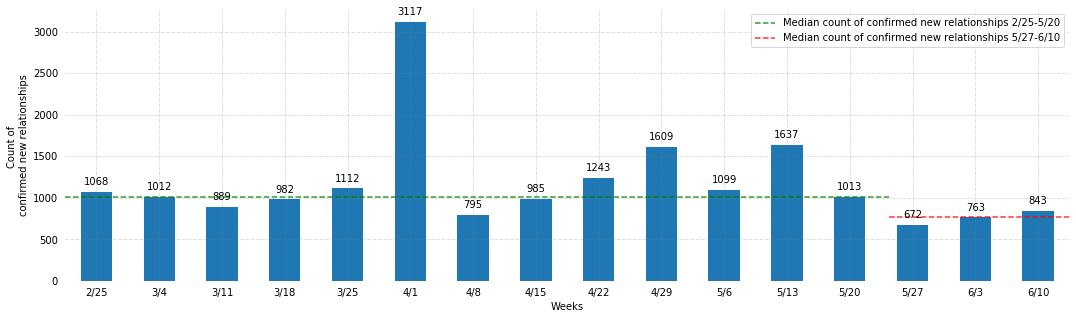

In [9]:
# Filter the confirmed relationships DataFrame to our targeted weeks
confirmed_relationships_by_week_filt = confirmed_relationships_by_week.iloc[8:24]

# Plot the count of confirmed new brand relationships by week
ax5 = confirmed_relationships_by_week_filt.plot(kind='bar', figsize=(18,5), rot=0)

# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax5.spines[s].set_visible(False) 
    
# Remove x, y Ticks 
ax5.xaxis.set_ticks_position('none') 
ax5.yaxis.set_ticks_position('none') 

# Add x, y gridlines 
ax5.grid(b=True, color='grey', 
        linestyle='-.', linewidth=0.5, 
        alpha=0.5)

# Calculate confirmed relationship averages
med_conf_relationships = confirmed_relationships_by_week_filt.median().iloc[0]
med_conf_relat_last_weeks = confirmed_relationships_by_week_filt.iloc[-3:].median().iloc[0]

# Plot confirmed relationship averages
line5 = ax5.axhline(y=med_conf_relationships, xmax=0.82, color='g', linestyle='--', alpha=0.8)
line6 = ax5.axhline(y=med_conf_relat_last_weeks, xmin=0.82, color='r', linestyle='--', alpha=0.8)
ax5.legend((line5, line6), (
    'Median count of confirmed new relationships 2/25-5/20',
    'Median count of confirmed new relationships 5/27-6/10'))
ax5.set_xlabel('Weeks')
ax5.set_ylabel('Count of \nconfirmed new relationships')
ax5.set_xticklabels(week_labels)
add_value_labels(ax5)

# Calculate percentage decrease in weeks 22-24
pct_decrease = ((med_conf_relat_last_weeks - med_conf_relationships) / med_conf_relationships) * 100

Due to a large outlier on 4/1, we'll use the median instead of the mean as our metric.

The data show:
   - **1,012** median confirmed brand-retailer relationships per week.
   - **763** median confirmed brand-retailer relationships during weeks between 5/27 and 6/10.
   - **24.6%** decrease in median confirmed brand-retailer relationships during weeks between 5/27 and 6/10.
   
   
   - This **confirms** the second step in our hypothesis - **fewer retailers signed up for Faire Direct during weeks between 5/27 and 6/10.**

> **In conclusion:** We can deduce from Hypothesis 2 that the decrease in new retailers acquired between 5/27 and 6/10 can be explained in part by:
> - New retailer sign-ups are highly correlated with confirmed first orders.
> - Fewer retailers joined Faire Direct during weeks between 5/27 and 6/10.

## Product recommendation

After confirming our second hypothesis, we have two key takeaways:  
1. There is a strong correlation between weekly retailer sign-ups and weekly first confirmed orders.
2. Fewer retailers signed up for Faire Direct in weeks between 5/27 and 6/10.  

To address these takeaways, I propose:

**Reducing the friction between retailer click through and Faire Direct sign-up.**
   - By shortening the onboarding flow and making it easier for retailers to sign up for Faire Direct after clicking through a brand invite, more retailers with onboard onto the platform and place first confirmed orders. 
    
   **Goal:** Increase the percentage of retailer click-throughs to sign-ups by 10%. 
    
   **Measurement:** Conduct an A/B test with randomly sampled cohorts of retailers to experience a shorter onboarding flow after clicking through a brand invitation. 
    
   **Lift:** 4 Design story points to shorten the onboarding flow. 6 Engineering story points to implement and 2 story points to test.   
    
   **ROI:** I estimate that the impact of hitting the goal will be a 1% increase in new retailers acquired YoY, leading to a \\$100,000 annual revenue increase.



# 3. Retailer first orders
---

**Hypothesis: Retailers place most first confirmed orders within a week of joining Faire Direct. Fewer retailers joined Faire Direct between 5/27 and 6/10.**  

To test this hypothesis, we will:  

**a**. Investigate when retailers are most likely to place their first orders.  
**b**. Invesitgate how many retailers joined Faire Direct between 5/27 and 6/10.

**3a. When are retailers most likely to place their first orders?**  

   - We'll use the difference between `retailer_placed_first_confirmed_order_at` and `brand_relationship_confirmed_at` to calculate the number of days between a retailer joining Faire Direct and making their first confirmed order.
   - Then we'll plot a histogram of these date differences to understand the distribution of first confirmed ordering behavior.

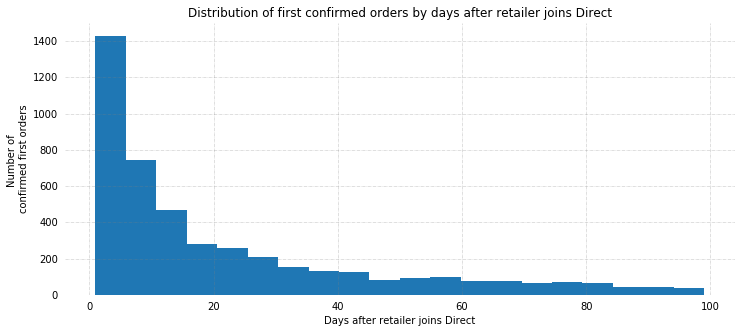

In [10]:
# Calculate the difference in dates between retailer_placed_first_confirmed_order_at 
# and brand_relationship_confirmed_at

retailers_with_confirmed_orders['order_dif'] = (
    retailers_with_confirmed_orders['retailer_placed_first_confirmed_order_at'] - retailers_with_confirmed_orders['brand_relationship_confirmed_at']).dt.days

# Trim outliers and plot
ax6 = retailers_with_confirmed_orders.loc[(
    retailers_with_confirmed_orders['order_dif'] < 100) & (
    retailers_with_confirmed_orders['order_dif'] > 0), 'order_dif'].hist(figsize=(12,5), bins=20)

ax6.set_xlabel('Days after retailer joins Direct')
ax6.set_ylabel('Number of \nconfirmed first orders')
ax6.set_title('Distribution of first confirmed orders by days after retailer joins Direct', loc='center')

# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax6.spines[s].set_visible(False) 
    
# Remove x, y Ticks 
ax6.xaxis.set_ticks_position('none') 
ax6.yaxis.set_ticks_position('none') 

# Add x, y gridlines 
ax6.grid(b=True, color='grey', 
        linestyle='-.', linewidth=0.5, 
        alpha=0.5)

- The histogram above shows that the distrubution of first confirmed orders is heavily weighted towards the first 7 days after a retailer joins Faire Direct.
- This **confirms** the first step in our hypothesis - **retailers tend to make their first confirmed purcashes within 7-10 days after joining Faire Direct.** 


**3b: How many new brand relationships were confirmed in weeks between 5/27 and 6/10 compared to an average week?**  
   - As we showed in section **2b**, we saw a 24.6% decrease in median retailer sign-ups in weeksbetween 5/27 and 6/10.
   - This **confirms** the second step in our hypothesis - **fewer retailers joined Faire Direct between 5/27 and 6/10.**


> **In conclusion:** We can deduce from Hypothesis 3 that the decrease in new retailers acquired between 5/27 and 6/10 can be explained in part by:
> - Retailers are most likely to place their first confirmed order within 7-10 days of joining Faire Direct.
> - Fewer retailers joined Faire Direct between 5/27 and 6/10.

## Product recommendation

After confirming our third hypothesis, we have two key takeaways:

1. Retailers tend to make their first confirmed orders with 7-10 days of joining Faire Direct.
2. Fewer retailers joined Faire Direct between 5/27 and 6/10.  
 
To address these takeaways, I propose: 

**Auto-populating retailer carts with recommendation engine suggestions 14 days after joining Faire Direct.**
- By increasing a retailer's awareness of products suggested by Faire's recommendation engine, this product change will drive the completion of first confirmed orders after a retailer has spent two weeks on the platform without ordering.

   **Goal:** Of retailers who haven't ordered within 14 days of joining Faire Direct, increase the percentage of those who order in days 14-21 by 50%. 
    
   **Measurement:** Conduct an A/B test with randomly sampled cohorts of retailers with the treatment condition being  a cart auto-populated with 3 personalized suggestions from Faire's recommendation engine. 
    
   **Lift:** 10 Engineering story points to implement and 2 story points to test.   
    
   **ROI:** I estimate that the impact of hitting the goal will be a 10% increase in new retailers acquired YoY, leading to a \\$1,000,000 annual revenue increase.


# Summary
---

### The problem:

- Faire Direct has experienced a 26.5% decrease in new retailer acquisitions (i.e. first confirmed orders) in recent weeks.

### The explanatory hypotheses:

1. Brands send more invites to retailers within 14 days of adopting Faire Direct, and fewer brands adopted Faire Direct between 5/27 and 6/10.
2. Retailer sign-ups are highly correlated with confirmed first orders, and fewer retailers signed-up during weeks between 5/27 and 6/10.
3. Most retailers make their confirmed first orders within 7-10 days of joining Faire Direct, and fewer retailers joined Faire Direct between 5/27 and 6/10.

### The product solutions:
1. Nudging brands to invite retailers at 2, 4, and 6 weeks after the brand adopts Faire Direct.
2. Increasing incentives for brands to join Faire Direct during down weeks.
3. Reducing the friction in retailer onboarding from invite click-through to confirmed sign-up.
4. Auto-populating retailer carts with recommendation engine suggestions 14 days after joining Faire Direct.


## Thank you
---

Thank you for reading my analytics case! I hope you enjoyed it as much as I enjoyed making it. Access this notebook and explore its code on [Github](https://github.com/jwkeane1/Faire_Direct_Analytics_Case.git).